In [49]:
import os
import json
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [29]:
def class_distribution(df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for idx, label_type in enumerate(['clean_label', 'noisy_label']):
        axs[idx].bar(df[label_type].value_counts().sort_index().index,
                    df[label_type].value_counts().sort_index().values)
        axs[idx].set_title(label_type)
        axs[idx].set_xticks(df[label_type].value_counts().sort_index().index)

    plt.suptitle(f'{label_type} distribution')
    plt.show()

In [38]:
def corruption_plot(df):
    clean_df = df[df['noisy_label'] == df['clean_label']]
    corrupted_df = clean_df[clean_df['mean'].round().astype(int) != clean_df['noisy_label']]
    # Data for the plot
    categories = clean_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(clean_df[clean_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrupted_df[corrupted_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='green', label='Clean Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='red', label='Corrupted Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Clean Labels = {len(clean_df)}, Total Corrupted Labels = {len(corrupted_df)}, Corruption Ratio = {round(len(corrupted_df)/len(clean_df), 4)}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [35]:
def correction_plot(df):
    noisy_df = df[df['noisy_label'] != df['clean_label']]
    corrected_df = noisy_df[noisy_df['mean'].round().astype(int) == noisy_df['clean_label']]
    # Data for the plot
    categories = noisy_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(noisy_df[noisy_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrected_df[corrected_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='orange', label='Noisy Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='blue', label='Corrected Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Noisy Labels = {len(noisy_df)}, Total Corrected Labels = {len(corrected_df)}, Correction Ratio = {round(len(corrected_df)/len(noisy_df), 4)}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [44]:
def sigma_plot(df): 
    # Sigma Analysis
    sigma_clean = df[df['mean'].round() == df['clean_label']]['sigma']
    sigma_noisy = df[df['mean'].round() != df['clean_label']]['sigma']

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Plot sigma histograms
    sns.histplot(sigma_clean, color='green', bins=30, alpha=0.8, ax=axes[0])
    axes[0].set_title('Sigma Distribution (Clean Data)')
    axes[0].set_xlabel('Sigma')
    axes[0].set_ylabel('Frequency')

    sns.histplot(sigma_noisy, color='red', bins=30, alpha=0.8, ax=axes[1])
    axes[1].set_title('Sigma Distribution (Noisy Data)')
    axes[1].set_xlabel('Sigma')

    plt.tight_layout()
    plt.show()

In [21]:
def display_sample_cases(df, n=3, high_sigma=True):
    sample = df.sort_values('sigma', ascending=not high_sigma).head(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i, (idx, row) in enumerate(sample.iterrows()):
        img = plt.imread(row['img_path'])
        axs[i].imshow(img)
        axs[i].set_title(f"Noisy: {row['noisy_label']}\nClean: {row['clean_label']}\nMean: {row['mean']}\nSigma: {row['sigma']:.2f}")
        axs[i].axis('off')
    plt.suptitle(f"Sample {'High' if high_sigma else 'Low'} Sigma Cases")
    plt.show()

In [50]:
def label_confusion(df):
    # 1. Confusion Matrix: Noisy vs. Corrected vs. Clean
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    copy_df = copy.deepcopy(df)
    # Discretize the `mean` column to match `clean_label`
    copy_df['mean_discretized'] = copy_df['mean'].round().astype(int)

    # Confusion matrices
    confusion_noisy_clean = confusion_matrix(copy_df['noisy_label'],
                                            copy_df['clean_label'])
    # Compute confusion matrix for corrected means vs. clean labels
    confusion_corrected_clean = confusion_matrix(
        copy_df['mean_discretized'], 
        copy_df['clean_label']
    )

    # Plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay(confusion_noisy_clean).plot(ax=ax[0], cmap='Blues')
    ax[0].set_title('Noisy Label vs. Clean Label')
    ConfusionMatrixDisplay(confusion_corrected_clean).plot(ax=ax[1], cmap='Blues')
    ax[1].set_title('Corrected Mean vs. Clean Label')
    plt.tight_layout()
    plt.show()

In [25]:
def get_df(noisy_root, clean_root):
    # List of CSV files
    files = [os.path.join(noisy_root, f'data_split{i}.csv') for i in range(5)]

    # List to store filtered data
    filtered_data = []

    # Read files and filter data
    ids = list()
    for file in files:
        df = pd.read_csv(file, header=None)  # No header in the files
        for _, row in df.iterrows():
            id = row[0]
            folder = row[2]  # Third column is folder
            if id in ids or folder == 2:
                continue
            else:
                # if folder in [0, 1]:  # Only include rows where folder is 0 or 1
                    # Drop the folder column (index 2) and keep the rest
                filtered_row = row.drop(2).tolist()
                filtered_data.append(filtered_row)
                ids.append(id)

    # Create a new DataFrame from the filtered data
    # Define column names (assuming the original CSV files have no headers)
    columns = ["id", "img_path", "noisy_label", "mean", "sigma"]  # Adjust column names as needed
    df = pd.DataFrame(filtered_data, columns=columns)

    clean_file = os.path.join(clean_root, f"data_split0.csv")
    clean_df = pd.read_csv(clean_file, header=None)
    df['clean_label'] = clean_df[3]

    return df

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train

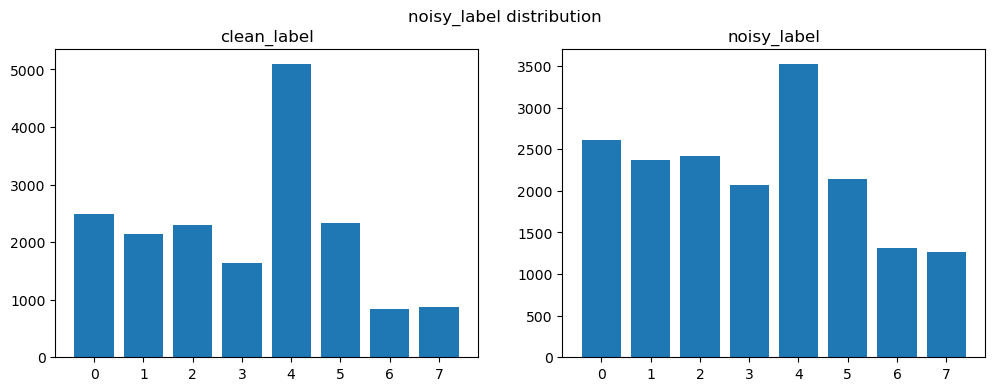

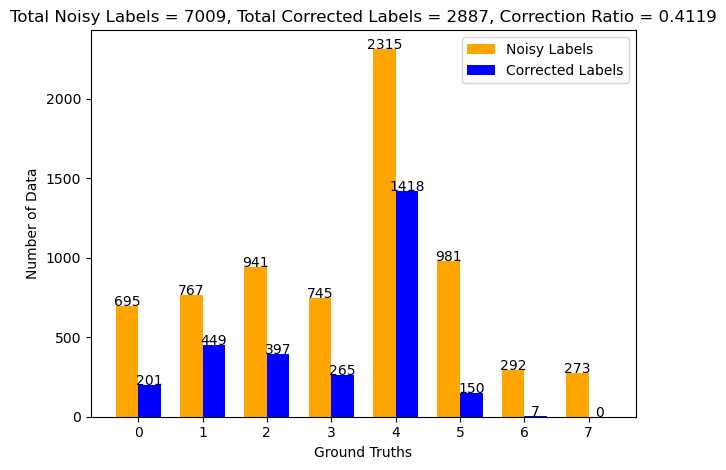

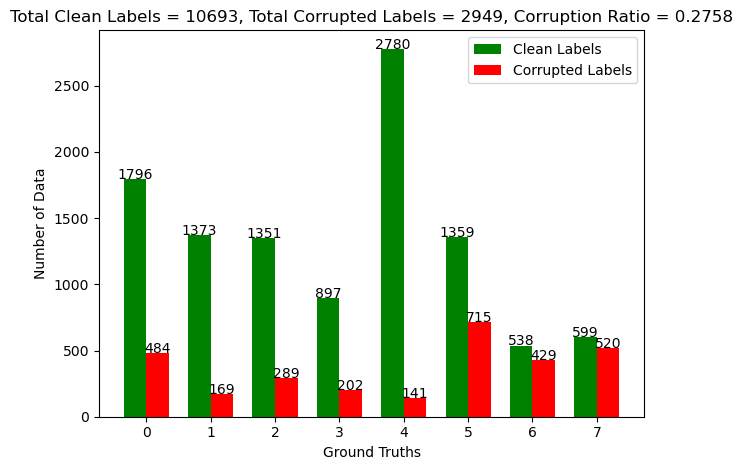

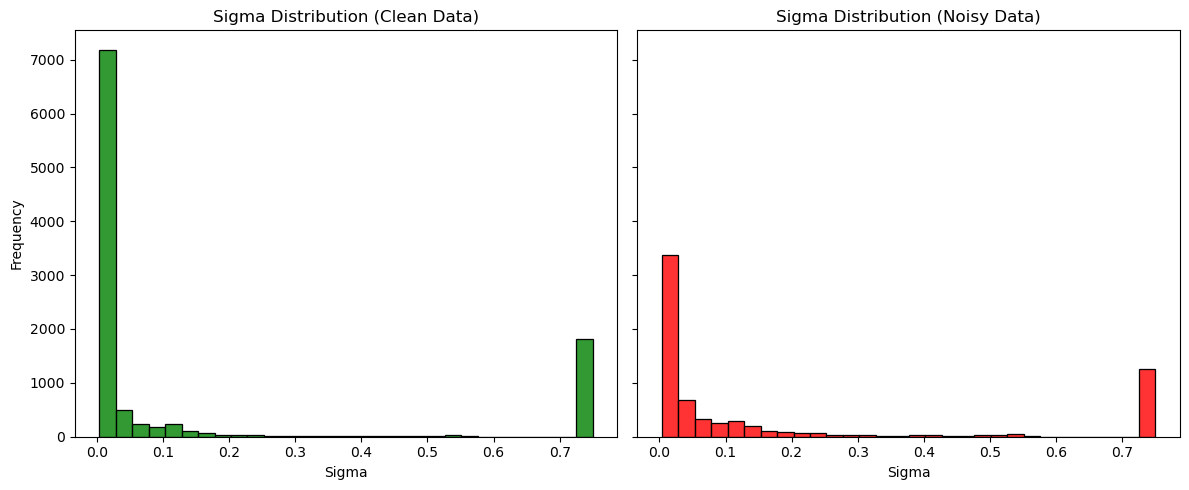

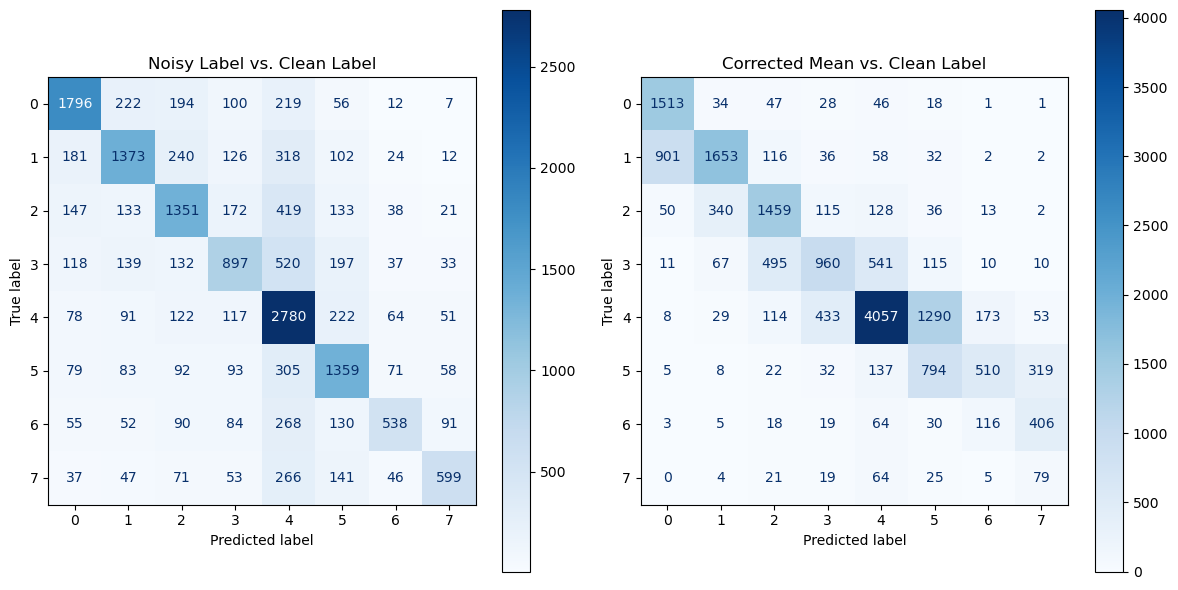

In [54]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val

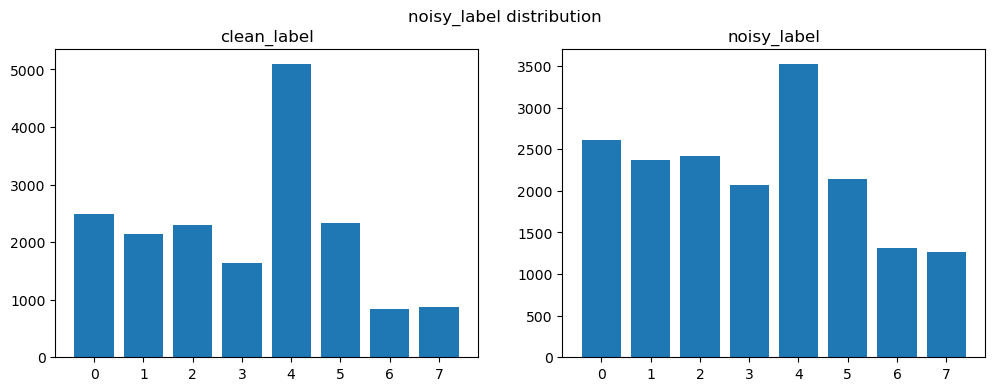

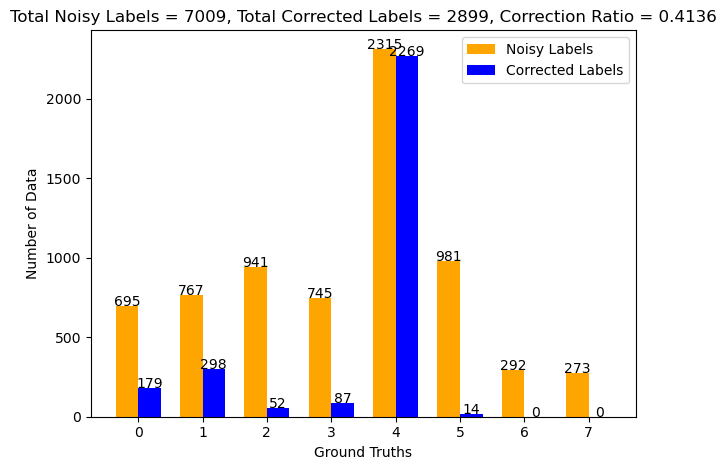

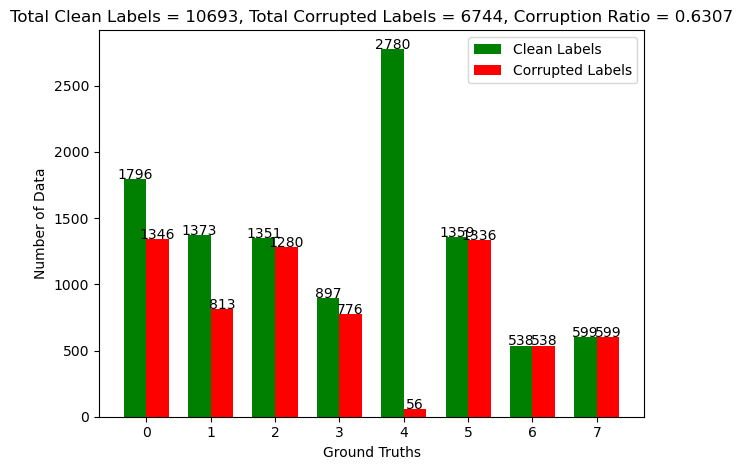

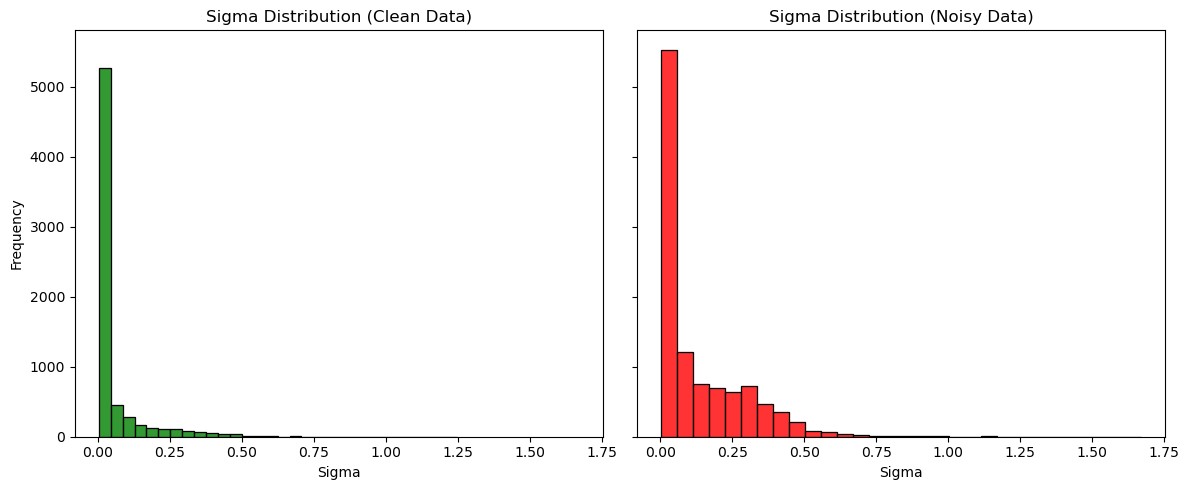

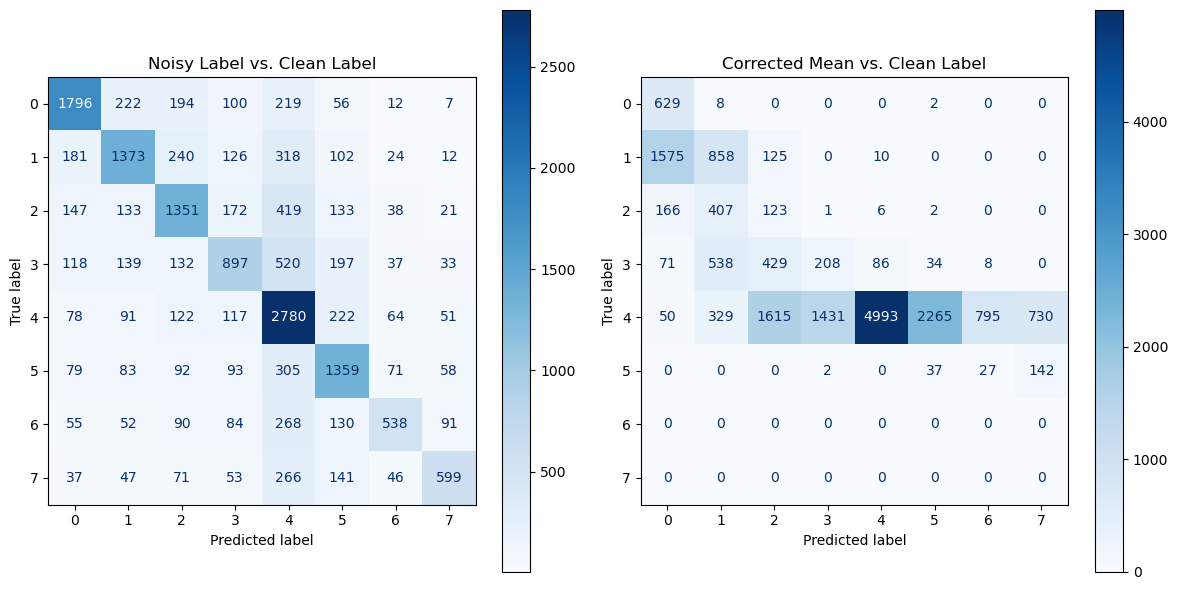

In [ ]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1

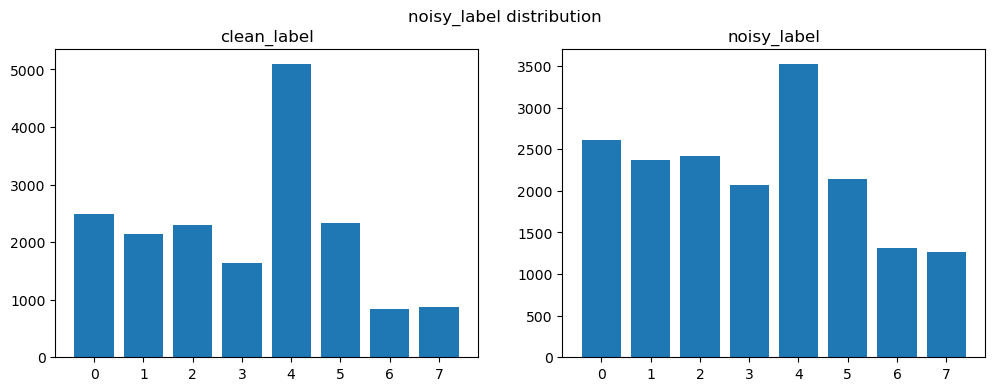

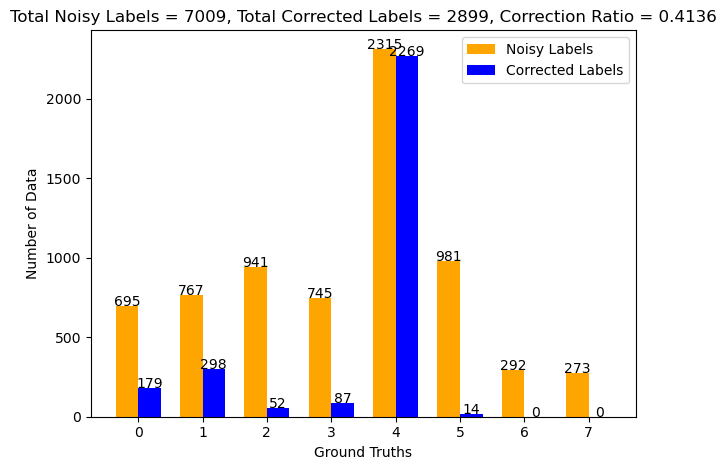

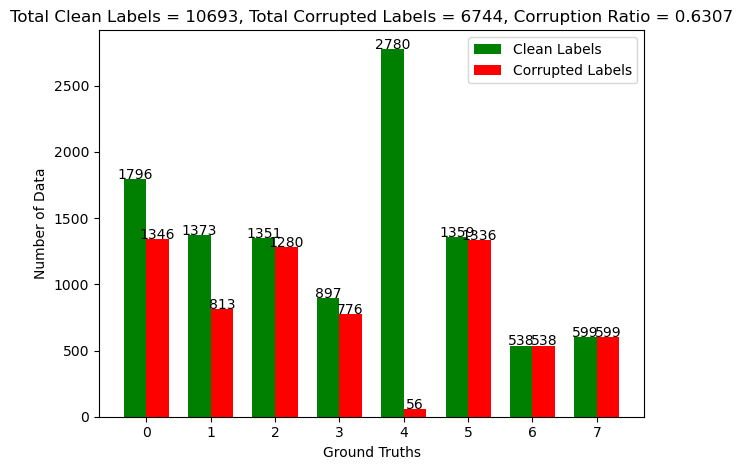

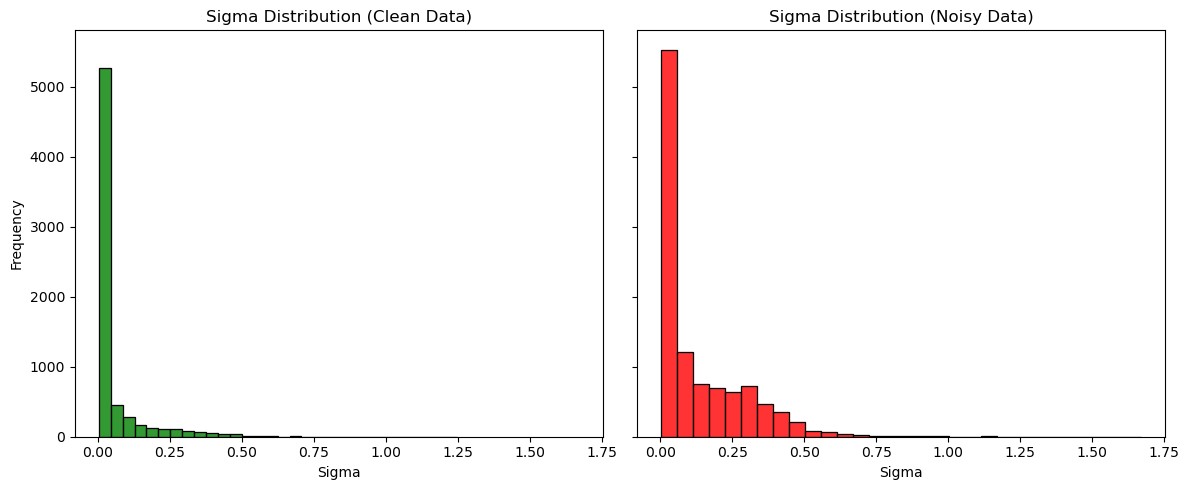

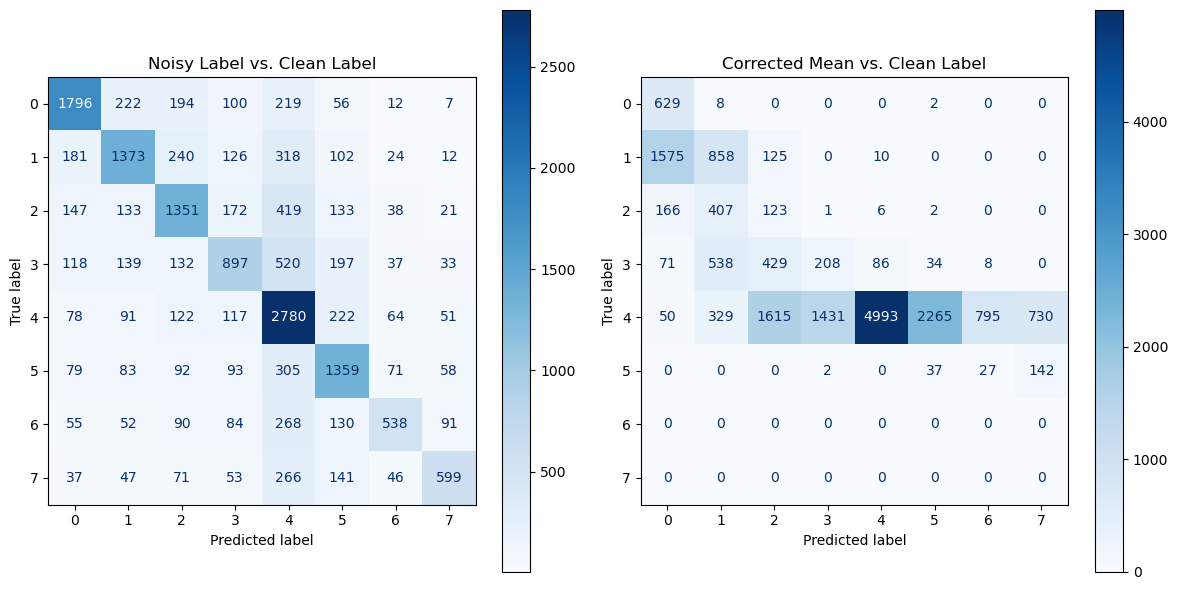

In [52]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)

### Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2

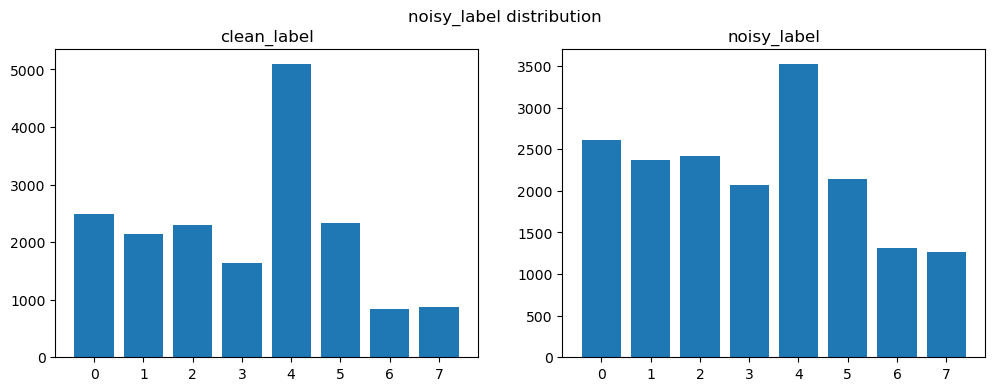

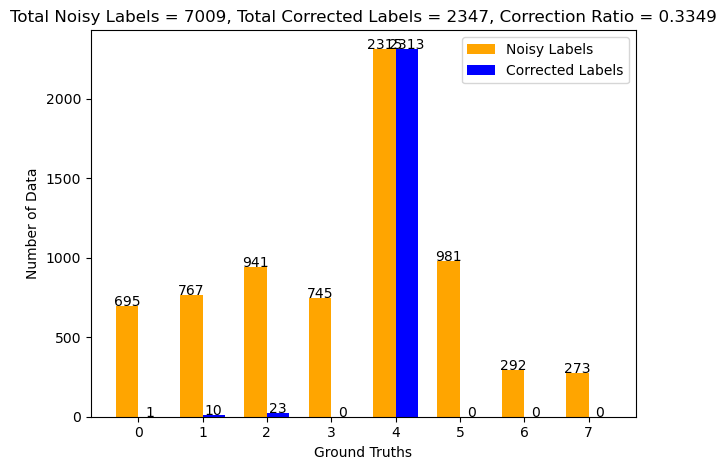

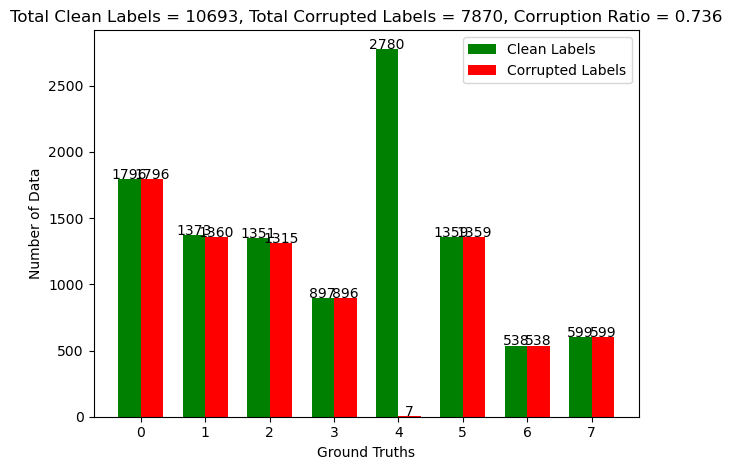

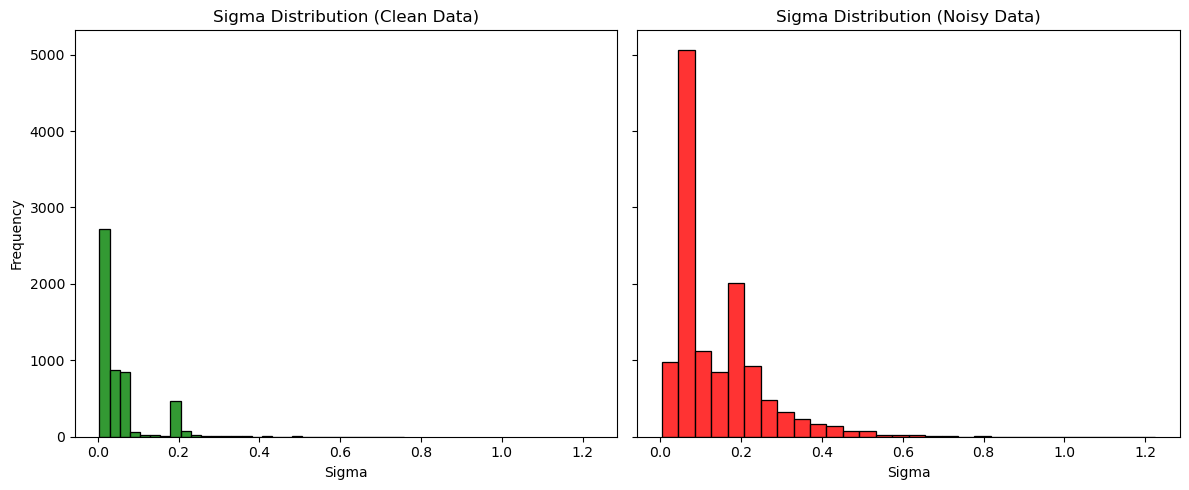

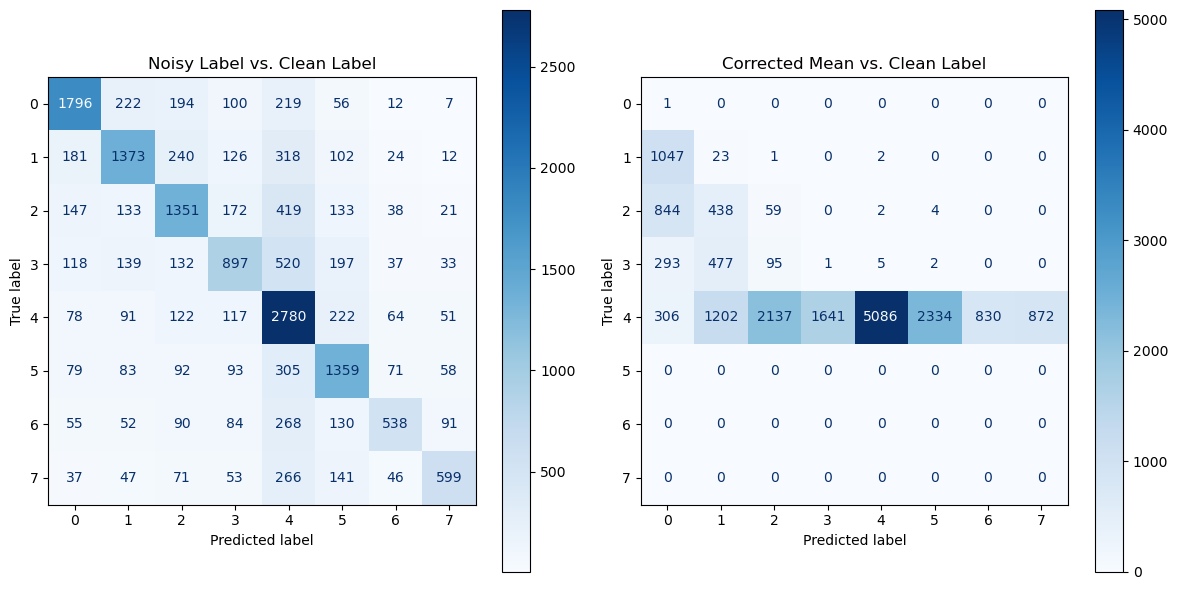

In [53]:
df = get_df(noisy_root='facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2',
            clean_root='facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

class_distribution(df)
correction_plot(df)
corruption_plot(df)
sigma_plot(df)
label_confusion(df)